<a href="https://colab.research.google.com/github/kishore779/Pytorch_Programming/blob/main/02_neural_network_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 02 Neural Network classification with PyTorch

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)


In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples : {X[:5]}")
print(f"First 5 labels : {y[:5]}")

First 5 samples : [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 labels : [1 1 1 1 0]


In [ ]:
import pandas as pd

circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


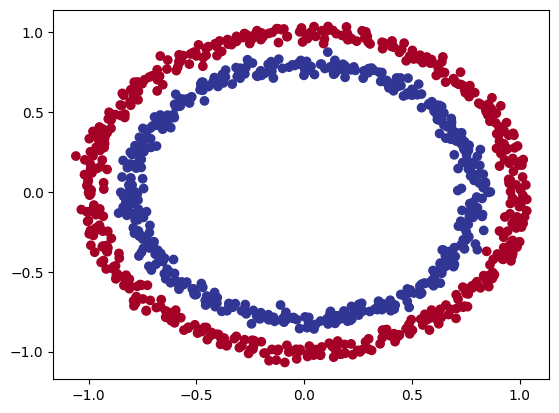

In [ ]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

##Turn data into tensor and split the data

In [ ]:
import torch
torch.__version__

'2.9.0+cu126'

In [ ]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
#Spilt the data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state= 42)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [ ]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Building a model

In [ ]:
from sklearn import datasets

class CircularModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

model_0 = CircularModelV0().to(device)
model_0

CircularModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

## By using the Sequential module

 * model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_0


In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5869,  0.1029],
                      [ 0.4620,  0.3034],
                      [-0.3560,  0.0809],
                      [-0.0557,  0.5680],
                      [-0.2364, -0.7008]])),
             ('0.bias', tensor([ 0.0777,  0.2221, -0.5115, -0.5768,  0.2716])),
             ('1.weight',
              tensor([[-0.1989, -0.0140,  0.2568,  0.4255, -0.2338]])),
             ('1.bias', tensor([-0.0693]))])

In [ ]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds[:10]

tensor([[-0.3012],
        [-0.2109],
        [-0.3846],
        [-0.2782],
        [-0.1414],
        [-0.0882],
        [-0.0268],
        [ 0.0026],
        [-0.3947],
        [-0.2022]], device='cuda:0')

## Set up a loss function and optimizer

In [ ]:
##  loss_fn = nn.BCELoss()

loss_fn = nn.BCEWithLogitsLoss() # sigmoid fn activation

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## Training the model using the known steps from prev section

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3012],
        [-0.2109],
        [-0.3846],
        [-0.2782],
        [-0.1414]], device='cuda:0')

In [ ]:
## use sigmoid activation fn

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [ ]:
y_preds = torch.round(y_pred_probs)

y_pred_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(),y_pred_label.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

## Building a training and Testing Loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss and acc
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  # optimizer zero_grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # optimizer step
  optimizer.step()

  ## testing
  model_0.eval()
  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  if epoch % 10 == 0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}%")


Epoch:0 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%
Epoch:10 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%
Epoch:20 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%
Epoch:30 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%
Epoch:40 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%
Epoch:50 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%
Epoch:60 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%
Epoch:70 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%
Epoch:80 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%
Epoch:90 | Loss: 0.70142 | Acc: 48.25% | Test_loss: 0.70435 | Test_acc: 49.00%


In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("its already there")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

its already there


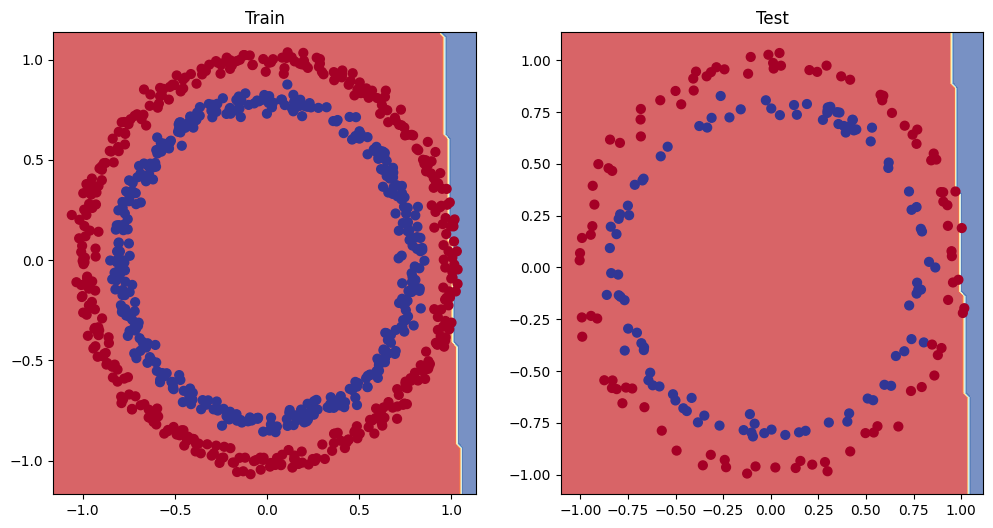

In [ ]:
# plot decision boundry

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)